# Filter data for Predictive maintenance = Time To Event Model
* We'll filter for HDDs that failed in the given year (both for convenience and file size).
* We will later use this data to create a regression model - time to failure. 

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import random
from scipy import stats

In [2]:
df_hdds = pd.read_csv('harddrive.csv')
print(df_hdds.shape)
df_hdds.head()

(3179295, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#*Data_Cleaning*#

# drop null columns
df = df_hdds.loc[:, ~df_hdds.isnull().all()]

# drop constant columns
df = df.loc[:, (df != df.iloc[0]).any()] 

#drop raw data columns
df = df.drop(df.filter(regex='raw').columns,axis=1)

#turn the object date into date type
df["date"] = pd.to_datetime(df["date"])

print(df.shape)

(3179295, 48)


In [4]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,...,smart_224_normalized,smart_225_normalized,smart_226_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,smart_250_normalized,smart_251_normalized,smart_252_normalized,smart_254_normalized
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,135.0,143,100,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,NaN,96,100,100,...,NaN,NaN,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,136.0,124,100,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,136.0,137,100,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,NaN,175,100,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#filling null values
for column in df:
     if(df[column].isnull().any()):
        df[column].fillna(df[column].mean(),inplace=True)

In [6]:
print(df.isnull().sum().any())

False


In [7]:
#*Feautre engineering part*#
failed_hdds = df.loc[df.failure==1]["serial_number"] #serial numbers

df_failed = df.loc[df["serial_number"].isin(failed_hdds)] #whole records


df_not_failed_hdds=df.copy()
cond = df_failed['serial_number'].isin(df_not_failed_hdds['serial_number']) == True
df_not_failed_hdds.drop(df_failed[cond].index, inplace = True)


In [8]:
print (df_not_failed_hdds.shape)
print (df_failed.shape)

(3173805, 48)
(5490, 48)


In [9]:
df_not_failed_jan = df_not_failed_hdds.loc[df_not_failed_hdds['date'].dt.month==1]["serial_number"] #only the serial numbers
df_not_failed_apr = df_not_failed_hdds.loc[df_not_failed_hdds['date'].dt.month==4]["serial_number"] 

In [10]:
df_jan = df_not_failed_hdds.loc[df_not_failed_hdds["serial_number"].isin(df_not_failed_jan)] #whole rows
df_apr = df_not_failed_hdds.loc[df_not_failed_hdds["serial_number"].isin(df_not_failed_apr)]

In [11]:
df_failed_in_gap = df_jan.copy()
cond2 = df_jan['serial_number'].isin(df_apr['serial_number']) == True
df_failed_in_gap.drop(df_jan[cond2].index, inplace = True)

In [12]:
df_healthy=df_not_failed_hdds.copy()
cond3 = df_not_failed_hdds['serial_number'].isin(df_failed_in_gap['serial_number']) == True
df_healthy.drop(df_not_failed_hdds[cond3].index, inplace = True)

In [13]:
print (df_failed_in_gap.shape)
print (df_healthy.shape)

(13837, 48)
(3159968, 48)


In [14]:
df_failed.is_copy = None
df_failed_in_gap.is_copy = None
df_healthy.is_copy = None

df_failed["end_date"] = df_failed.groupby("serial_number")["date"].transform("max")
df_failed["date_diff"] = df_failed["end_date"] - df_failed["date"]
df_failed["date_diff"] = df_failed["date_diff"].dt.days

end_date =[]
for i in range (df_failed_in_gap.shape[0]):
    d =pd.Timestamp("2016-0"+str(random.randint(2,3))+"-"+str(random.randint(1,29)))
    end_date.append(d)
    
df_failed_in_gap["end_date"]=end_date

df_failed_in_gap["date_diff"] = df_failed_in_gap["end_date"] - df_failed_in_gap["date"]
df_failed_in_gap["date_diff"] = df_failed_in_gap["date_diff"].dt.days

df_healthy["date_diff"]=-1

C:\Users\HP\Miniconda3\lib\site-packages\pandas\core\generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\HP\Miniconda3\lib\site-packages\pandas\core\generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [15]:
frames=[df_failed,df_failed_in_gap,df_healthy]
df_train=pd.concat(frames, sort=False)

In [16]:
df_train.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,...,smart_226_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,smart_250_normalized,smart_251_normalized,smart_252_normalized,smart_254_normalized,end_date,date_diff
376,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,128.765198,91,100,100,...,100.0,100.0,100.0,100.0,1.0,6.412698,19.822222,116.131065,2016-01-17,16
1657,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,128.765198,97,100,100,...,100.0,100.0,100.0,100.0,1.0,6.412698,19.822222,116.131065,2016-04-09,99
1895,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,128.765198,91,100,100,...,100.0,100.0,100.0,100.0,1.0,6.412698,19.822222,116.131065,2016-04-18,108
2900,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,128.765198,92,100,100,...,100.0,100.0,100.0,100.0,1.0,6.412698,19.822222,116.131065,2016-04-09,99
3204,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,128.765198,91,100,100,...,100.0,100.0,100.0,100.0,1.0,6.412698,19.822222,116.131065,2016-01-10,9


In [17]:
print(df_train.shape)

(3179295, 50)


In [18]:
df_sample = df_train.sample(30000, random_state=1)
print (df_train.shape)
print (df_sample.shape)

(3179295, 50)
(30000, 50)


In [19]:
print(df_train.isnull().sum().any())

True


In [81]:
#Handling cateogrical variables 
Target=df_sample["date_diff"]
df_sample=df_sample.drop(["end_date","serial_number","date","date_diff","failure"],axis=1)
df_sample = pd.get_dummies(df_sample)



In [82]:
df_sample.head()


,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_8_normalized,smart_9_normalized,smart_10_normalized,smart_11_normalized,...,model_WDC WD2500BPVT,model_WDC WD30EFRX,model_WDC WD3200BEKX,model_WDC WD40EFRX,model_WDC WD5000BPKT,model_WDC WD5000LPVX,model_WDC WD5002ABYS,model_WDC WD60EFRX,model_WDC WD800BB,model_WDC WD800LB
714206,119,128.765198,91,100,100,84,115.948512,81,100,101.302103,...,0,0,0,0,0,0,0,0,0,0
1502213,100,252.000000,94,100,252,252,252.000000,100,252,100.000000,...,0,0,0,0,0,0,0,0,0,0
3046377,110,128.765198,91,100,100,87,115.948512,75,100,101.302103,...,0,0,0,0,0,0,0,0,0,0
1547229,100,133.000000,100,100,100,100,113.000000,98,100,101.302103,...,0,0,0,0,0,0,0,0,0,0
725541,95,100.000000,116,100,100,100,100.000000,94,100,101.302103,...,0,0,0,0,0,0,0,0,0,0


In [83]:
x=df_sample.values
scaler = StandardScaler()
scaled_data=scaler.fit_transform(x)
df_standarded=pd.DataFrame(scaled_data)

In [84]:
print(df_standarded.shape)
df_standarded.head()

(15000, 87)


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.364233,0.003038,-0.760254,0.012444,-0.215587,-0.411706,0.005751,-1.344597,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
1,-0.646894,7.926212,-0.602472,0.012444,6.155122,7.285737,9.066698,0.957214,9.881969,-0.467253,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
2,-0.114722,0.003038,-0.760254,0.012444,-0.215587,-0.274252,0.005751,-2.071484,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
3,-0.646894,0.275308,-0.286907,0.012444,-0.215587,0.321384,-0.190618,0.714918,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
4,-0.912980,-1.846371,0.554597,0.012444,-0.215587,0.321384,-1.056411,0.230326,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165


In [85]:
df_standarded = df_standarded.loc[:, (df_standarded != df_standarded.iloc[0]).any()] 
print(df_standarded.shape)

(15000, 80)


In [86]:
#remove outliers
for column in df_standarded:
    q = df_standarded[column].quantile(0.99)
    df_standarded[df_standarded[column] < q]

In [87]:
print(df_standarded.shape)
df_standarded.head()

(15000, 80)


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.364233,0.003038,-0.760254,0.012444,-0.215587,-0.411706,0.005751,-1.344597,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
1,-0.646894,7.926212,-0.602472,0.012444,6.155122,7.285737,9.066698,0.957214,9.881969,-0.467253,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
2,-0.114722,0.003038,-0.760254,0.012444,-0.215587,-0.274252,0.005751,-2.071484,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
3,-0.646894,0.275308,-0.286907,0.012444,-0.215587,0.321384,-0.190618,0.714918,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165
4,-0.912980,-1.846371,0.554597,0.012444,-0.215587,0.321384,-1.056411,0.230326,-0.100853,0.003559,...,-0.011548,-0.132812,-0.008165,-0.0231,-0.0231,-0.060664,-0.011548,-0.093501,-0.008165,-0.008165


In [88]:
print(df_standarded.isnull().sum().any())
print(Target.isnull().sum().any())

False
False


In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_standarded, Target, test_size=0.33, random_state=42)

In [90]:
clf = Pipeline([
  ('reg', RandomForestRegressor())
   ])

param_grid = [{       
    "reg__min_samples_split": [2,4,6,9],  
    "reg__n_estimators":[100,120,1000],
    "reg__max_depth": [2, 4,6,8]   
}]
clf.fit(X_train,y_train)

C:\Users\HP\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('reg',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [91]:
predictions=clf.predict(X_test)

print(mean_squared_error(predictions,y_test))
print(mean_absolute_error(predictions,y_test))

23.85031185653635
0.5542239800603438


Text(0, 0.5, 'Predictions')

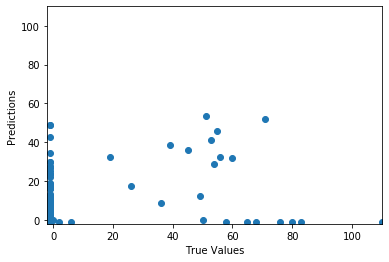

In [76]:
#Plotting the predictions and true values
from matplotlib import pyplot as plt
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.xlim(-2,110)
plt.ylim(-2,110)
plt.ylabel("Predictions")

In [77]:
from sklearn.metrics import r2_score
print(r2_score(predictions,y_test))

-0.9550231700214029


In [78]:
from sklearn.feature_selection import f_classif
X_new=SelectKBest(f_classif, k=6).fit(X_train, y_train)
clf.fit(X_new,y_train)

C:\Users\HP\Miniconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


TypeError: float() argument must be a string or a number, not 'SelectKBest'